In [1]:
import pandas as pd
import numpy as np
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
use_clusters = [
    'CA1_Ak5', 'CA1_Chrm3', 'CA1_Kif26a', 'CA1_Ptprg',
    'CA3_Cadm2', 'CA3_Efnb2', 'CA3-St18_Epha5', 'CA3-St18_Nuak1',
    'CA3-St18_Tead1', 'DG_dg-all', 'DG-po_Bcl11a', 'DG-po_Calb2',
    'DG-po_Kctd8', 'Gfra1_Gfra1', 'IG-CA2_Chrm3', 'IG-CA2_Peak1', 'IG-CA2_Xpr1'
]

## Final Results

In [3]:
cluster_from = 'CA1_Chrm3'
cluster_to = 'CA3_Cadm2'

with pd.HDFStore('FinalDMGDMR.h5') as f:
    dmr = f[f'{cluster_from}/{cluster_to}/DMR']
    dmg = f[f'{cluster_from}/{cluster_to}/Gene']
    corr = f[f'{cluster_from}/{cluster_to}/Corr']

## DMR Bed

In [4]:
with pd.HDFStore('/home/hanliu/project/mouse_rostral_brain/DMR/SubType/FilteredDMR.h5') as hdf:
    dmr_bed_df = hdf['Bed']
dmr_bed_df.index = 'Sub' + dmr_bed_df['#chr'] + '_' + dmr_bed_df.index.astype(str)
dmr_bed_df = dmr_bed_df.loc[dmr].copy()
dmr_bed = pybedtools.BedTool.from_dataframe(dmr_bed_df)

In [5]:
dmr_bed_df.shape

(13038, 4)

## Genemeta

In [118]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}

dmg_names = pd.Index(dmg.map(gene_meta['gene_name']))

## ATAC

In [60]:
peak_bed = pybedtools.BedTool(
    f'/home/hanliu/project/mouse_rostral_brain/study/mCClusterATACPeak/SubType/{cluster_from}.sorted.peak.bed'
)
peak_bed.count()

133993

In [109]:
dmr_open = dmr_bed.intersect(peak_bed, wa=True, v=True)
dmr_open.saveas('OpenDMR.bed')

dmr_open.count() / dmr_bed.count(), dmr_bed.count()

(0.7780334407117656, 13038)

## RNA

In [11]:
rna_cpm = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClusterRNACPM/SubType.CPM.msg'
)
rna_portion = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/mCClusterRNACPM/SubType.exp_portion.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


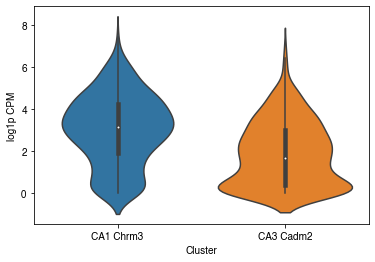

In [108]:
gene_has_rna = rna_cpm.index & dmg_names
try:
    use_data = rna_cpm.loc[gene_has_rna, [cluster_from.replace('_', ' '), cluster_to.replace('_', ' ')]]
    plot_data = np.log1p(use_data).unstack().reset_index()
    plot_data.columns = ['Cluster', 'Gene', 'log1p CPM']
    sns.violinplot(data=plot_data, x='Cluster', y='log1p CPM')
except KeyError:
    pass